## Setup

### PIP Install Packages and dependencies

In [ ]:
!pip install google-cloud-bigquery google-cloud-bigquery-storage --upgrade

In [2]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

{'status': 'ok', 'restart': True}

### Configure GCP environment settings

In [1]:
PROJECT_ID = 'cp2-final-project' # Change to your project.
REGION = 'US'

### Import libraries and define constants

In [2]:
from google.cloud import bigquery
import pandas as pd
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Import libraries for data manipulation and plotting

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_historical_and_forecast(input_timeseries, 
                                 timestamp_col_name, 
                                 data_col_name, 
                                 forecast_output=None, 
                                 actual=None, 
                                 title=None,
                                 plotstartdate=None):

    if plotstartdate:
        input_timeseries[timestamp_col_name] = pd.to_datetime(input_timeseries[timestamp_col_name])
        input_timeseries = input_timeseries[input_timeseries[timestamp_col_name] >= pd.to_datetime(plotstartdate)]
        
    input_timeseries = input_timeseries.sort_values(timestamp_col_name)    
    
    # Plot the input historical data
    plt.figure(figsize=(20,6))
    plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
    plt.xlabel(timestamp_col_name)
    plt.ylabel(data_col_name)

    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('forecast_timestamp')
        forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
        x_data = forecast_output['forecast_timestamp']
        y_data = forecast_output['forecast_value']
        confidence_level = forecast_output['confidence_level'].iloc[0] * 100
        low_CI = forecast_output['confidence_interval_lower_bound']
        upper_CI = forecast_output['confidence_interval_upper_bound']
        # Plot the forecast data
        plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
        # Shade the confidence interval
        plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4, 
                         label = f'{confidence_level} confidence interval')

    # Plot actual data
    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')   

    # Display title, legend
    plt.title(f'{title}', fontsize= 16)
    plt.legend(loc = 'upper center', prop={'size': 16})

### Create a BigQuery dataset

In [4]:
!bq mk --location=$REGION --dataset $PROJECT_ID:bqmlforecast

Dataset 'cp2-final-project:bqmlforecast' successfully created.


## Prepare the training data

In [5]:
%%bigquery --project $PROJECT_ID

SELECT 
    invoice_and_item_number,
    date,
    store_number,
    item_description,
    bottles_sold,
    sale_dollars
FROM
  `bigquery-public-data.iowa_liquor_sales.sales` 
LIMIT 
  5

Query is running:   0%|          |

Downloading:   0%|          |

,invoice_and_item_number,date,store_number,item_description,bottles_sold,sale_dollars
0,INV-23310000021,2019-11-18,5091,JAGERMEISTER LIQUEUR MINI MEISTERS,1,7.400
1,INV-23521600017,2019-11-26,4558,JAGERMEISTER LIQUEUR MINI MEISTERS,1,7.400
2,INV-24519900032,2020-01-13,5726,JAGERMEISTER LIQUEUR MINI MEISTERS,1,7.400
3,INV-19942500058,2019-06-11,4819,RUMCHATA MINICHATAS SUMMER TUMBLER VAP,1,7.500
4,S18606400015,2014-04-24,3926,THREE OLIVES ORANGE VODKA,120,2011.200


### Set the start and end dates for the training data

In [8]:
ARIMA_PARAMS = {
    'TRAININGDATA_STARTDATE': '2020-01-01',
    'TRAININGDATA_ENDDATE': '2021-06-01',
}
ARIMA_PARAMS

{'TRAININGDATA_STARTDATE': '2020-01-01', 'TRAININGDATA_ENDDATE': '2021-06-01'}

### Write the training data to a table

In [9]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

CREATE OR REPLACE TABLE bqmlforecast.training_data AS (
    WITH topsellingitems AS(
         SELECT 
            item_description,
            count(item_description) cnt_transactions
        FROM
            `bigquery-public-data.iowa_liquor_sales.sales` 
        GROUP BY 
            item_description
        ORDER BY cnt_transactions DESC
        LIMIT 5 #Top N
    )
    SELECT 
        date,
        item_description AS item_name,
        SUM(bottles_sold) AS total_amount_sold
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales` 
    GROUP BY
        date, item_name
    HAVING 
        date BETWEEN @TRAININGDATA_STARTDATE AND @TRAININGDATA_ENDDATE
        AND item_description IN (SELECT item_description FROM topsellingitems)
    );

SELECT 
    date,
    item_name,
    total_amount_sold
FROM 
    bqmlforecast.training_data 
ORDER BY item_name, date
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,date,item_name,total_amount_sold
0,2020-01-02,BLACK VELVET,2552
1,2020-01-03,BLACK VELVET,5202
2,2020-01-06,BLACK VELVET,3314
3,2020-01-07,BLACK VELVET,4033
4,2020-01-08,BLACK VELVET,2905
5,2020-01-09,BLACK VELVET,2528
6,2020-01-10,BLACK VELVET,4390
7,2020-01-13,BLACK VELVET,3858
8,2020-01-14,BLACK VELVET,4130
9,2020-01-15,BLACK VELVET,2779


### Plot the sales histories of the target liquor products

In [10]:
%%bigquery dfhistorical --project $PROJECT_ID 

SELECT 
    * 
FROM 
    bqmlforecast.training_data

Query is running:   0%|          |

Downloading:   0%|          |

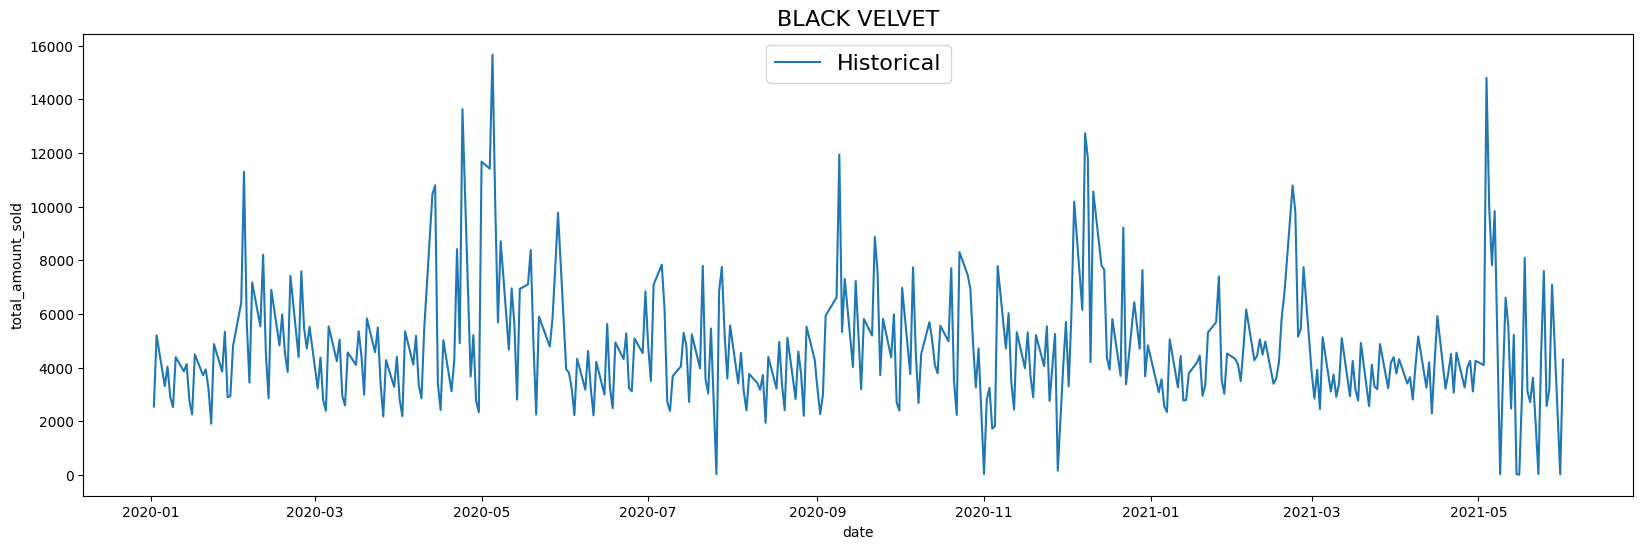

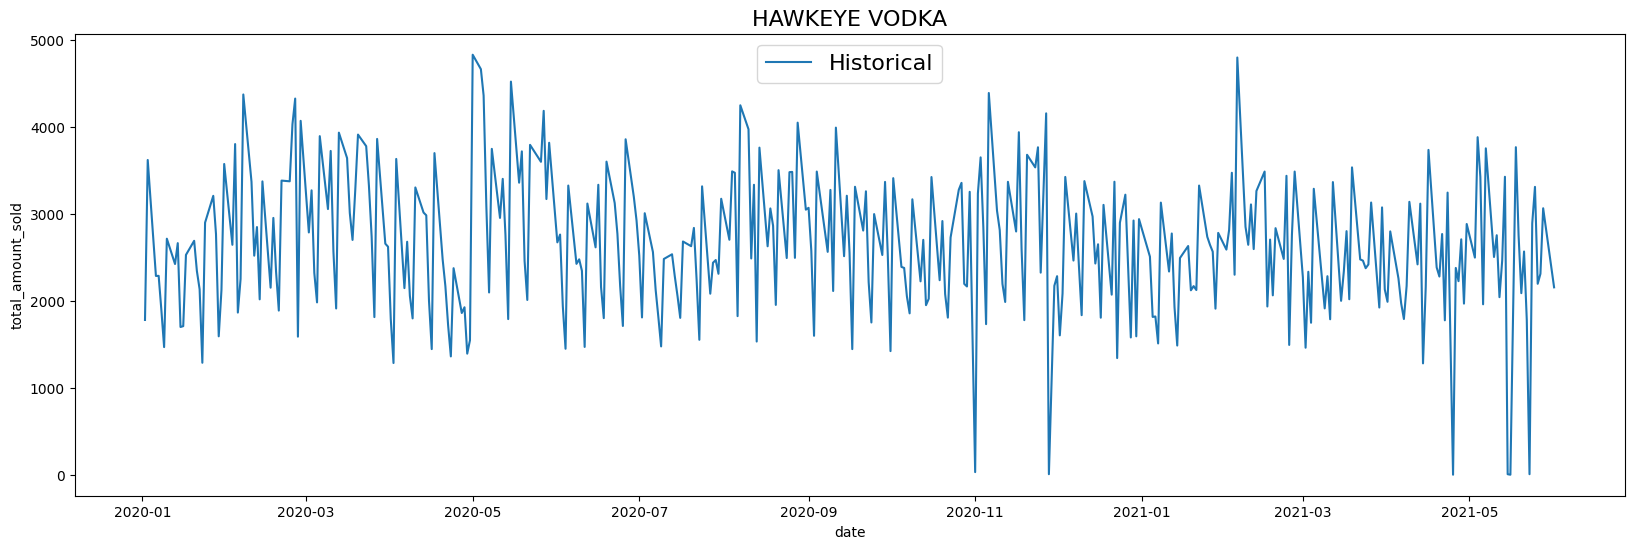

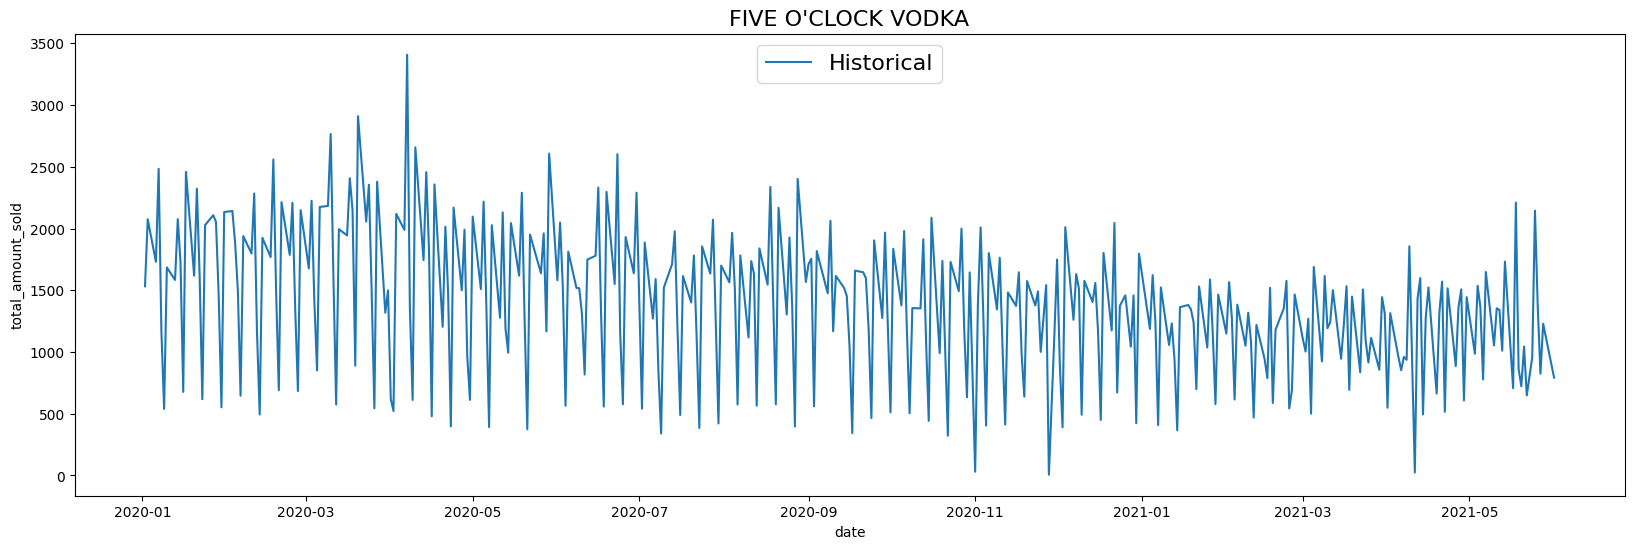

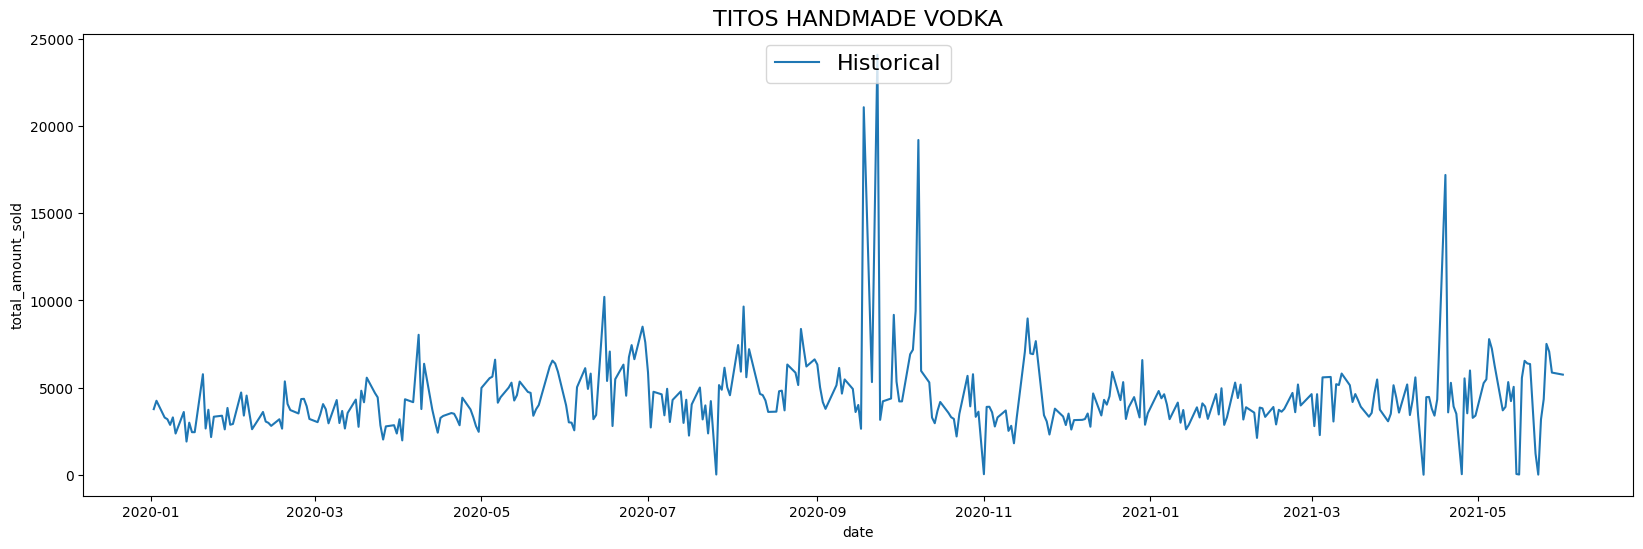

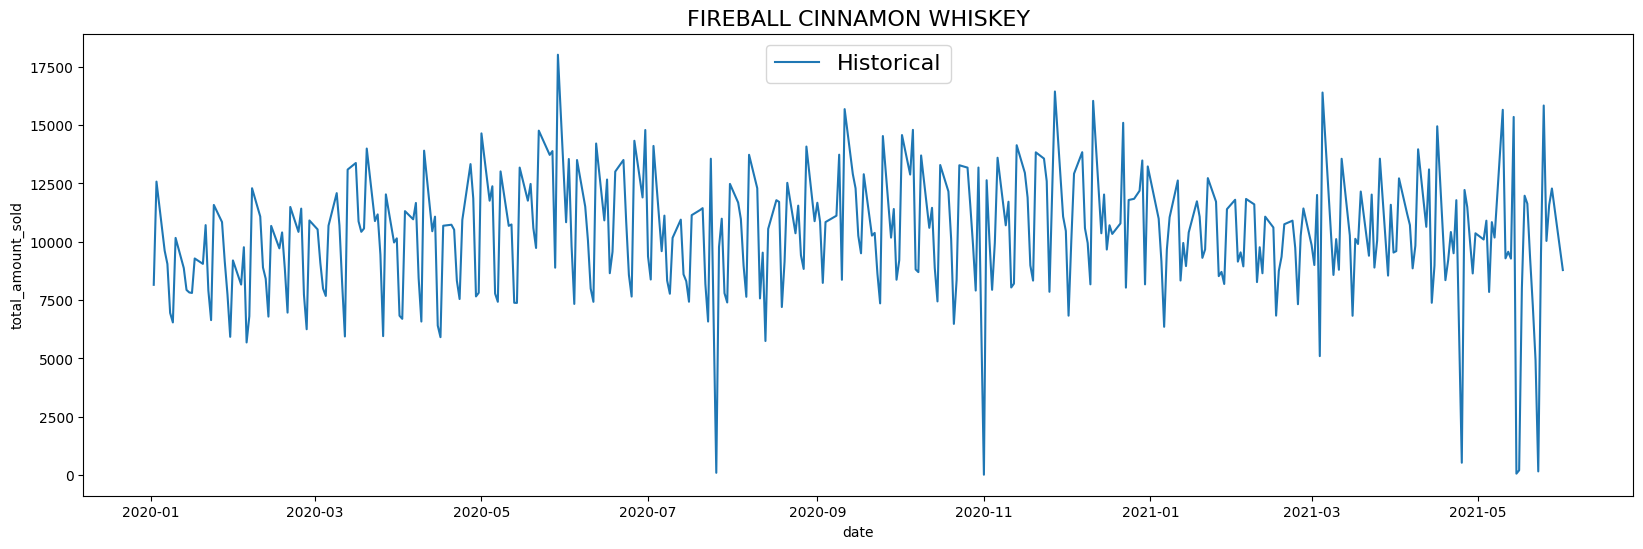

In [40]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    
    datah = dfhistorical[dfhistorical.item_name==item]
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "date", 
                                 data_col_name = "total_amount_sold", 
                                 forecast_output = None, 
                                 actual = None,
                                 title = item)

## Train the model

In [12]:
%%bigquery --project $PROJECT_ID 

CREATE OR REPLACE MODEL bqmlforecast.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date', 
  TIME_SERIES_DATA_COL='total_amount_sold',
  TIME_SERIES_ID_COL='item_name',
  HOLIDAY_REGION='US'
) AS

SELECT 
    date,
    item_name,
    total_amount_sold
FROM
  bqmlforecast.training_data

Query is running:   0%|          |

""


### Evaluate the model

In [13]:
%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlforecast.arima_model)

Query is running:   0%|          |

Downloading:   0%|          |

,item_name,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods
0,BLACK VELVET,3,0,2,False,-4115.544,8245.088,79586.899,[WEEKLY]
1,FIREBALL CINNAMON WHISKEY,1,1,4,False,-4431.198,8874.396,1651952.554,[WEEKLY]
2,FIVE O'CLOCK VODKA,0,1,5,True,-3412.730,6839.460,32027.355,[WEEKLY]
3,HAWKEYE VODKA,0,1,5,False,-3796.077,7604.153,140802.215,[WEEKLY]
4,TITOS HANDMADE VODKA,0,1,5,False,-4251.276,8514.552,814425.228,[WEEKLY]


## Make predictions using the model

In [29]:
%%bigquery dfforecast --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.95";

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL bqmlforecast.arima_model, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)

Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
dfforecast.head()

,item_name,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,BLACK VELVET,2021-06-02 00:00:00+00:00,-8575.906,282.112,0.950,-9127.845,-8023.967,-9127.845,-8023.967
1,BLACK VELVET,2021-06-03 00:00:00+00:00,5114.768,349.175,0.950,4431.621,5797.915,4431.621,5797.915
2,BLACK VELVET,2021-06-04 00:00:00+00:00,-2074.736,282.112,0.950,-2626.675,-1522.797,-2626.675,-1522.797
3,BLACK VELVET,2021-06-05 00:00:00+00:00,1735.690,411.210,0.950,931.175,2540.204,931.175,2540.204
4,BLACK VELVET,2021-06-06 00:00:00+00:00,-878.570,175.999,0.950,-1222.904,-534.236,-1222.904,-534.236


In [31]:
print(f"Number of rows: {dfforecast.shape[0]}")

Number of rows: 150


#### Inspect the model coefficients

In [32]:
%%bigquery --project $PROJECT_ID 

SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL bqmlforecast.arima_model)

Query is running:   0%|          |

Downloading:   0%|          |

,item_name,ar_coefficients,ma_coefficients,intercept_or_drift
0,BLACK VELVET,"[-0.6585305605805092, 0.6100020153311294, 0.62...","[1.7000691342229322, 0.9476484547004392]",4823.102
1,FIREBALL CINNAMON WHISKEY,[-0.8065003749369494],"[0.5539402932979657, -0.8283516868503932, -0.4...",0.000
2,FIVE O'CLOCK VODKA,[],"[-0.8068799754854225, -0.24542775837489808, 0....",-1.529
3,HAWKEYE VODKA,[],"[-0.3203511596940588, 0.12343423276667076, -0....",0.000
4,TITOS HANDMADE VODKA,[],"[-0.3983819079604901, -0.6917627987339272, 0.7...",0.000


#### Plot the forecasted predictions against the historical data

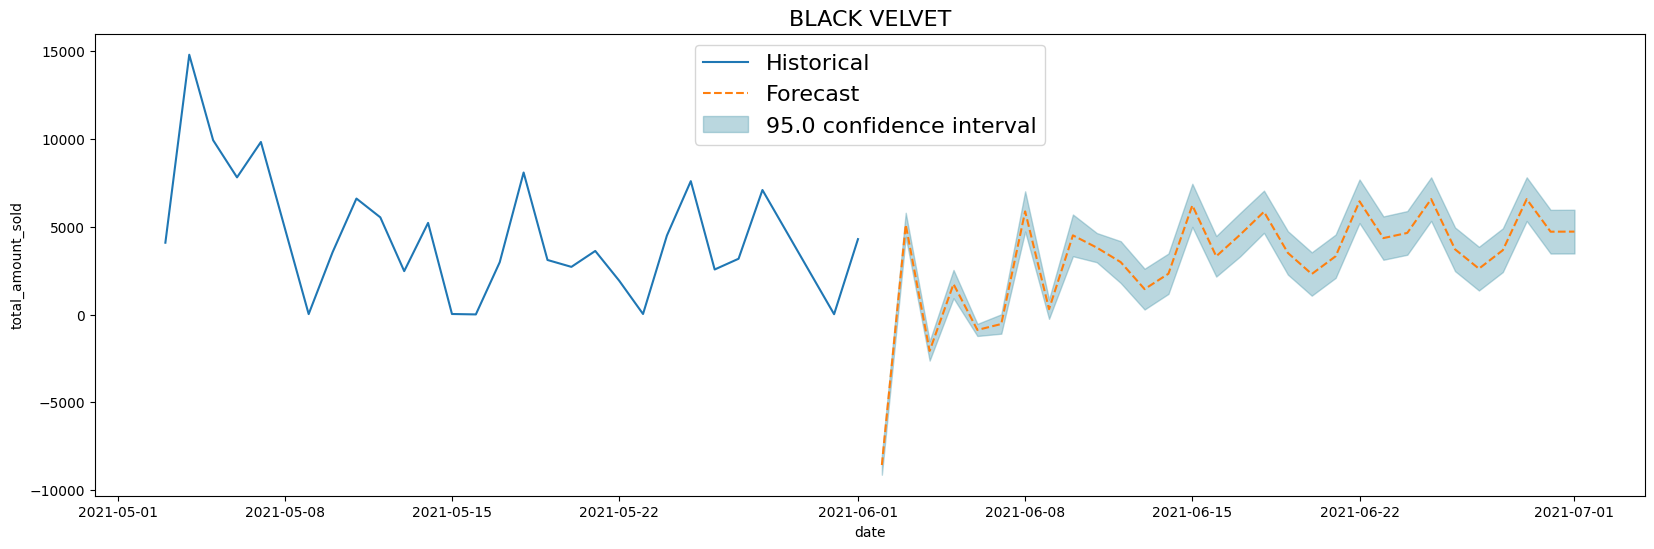

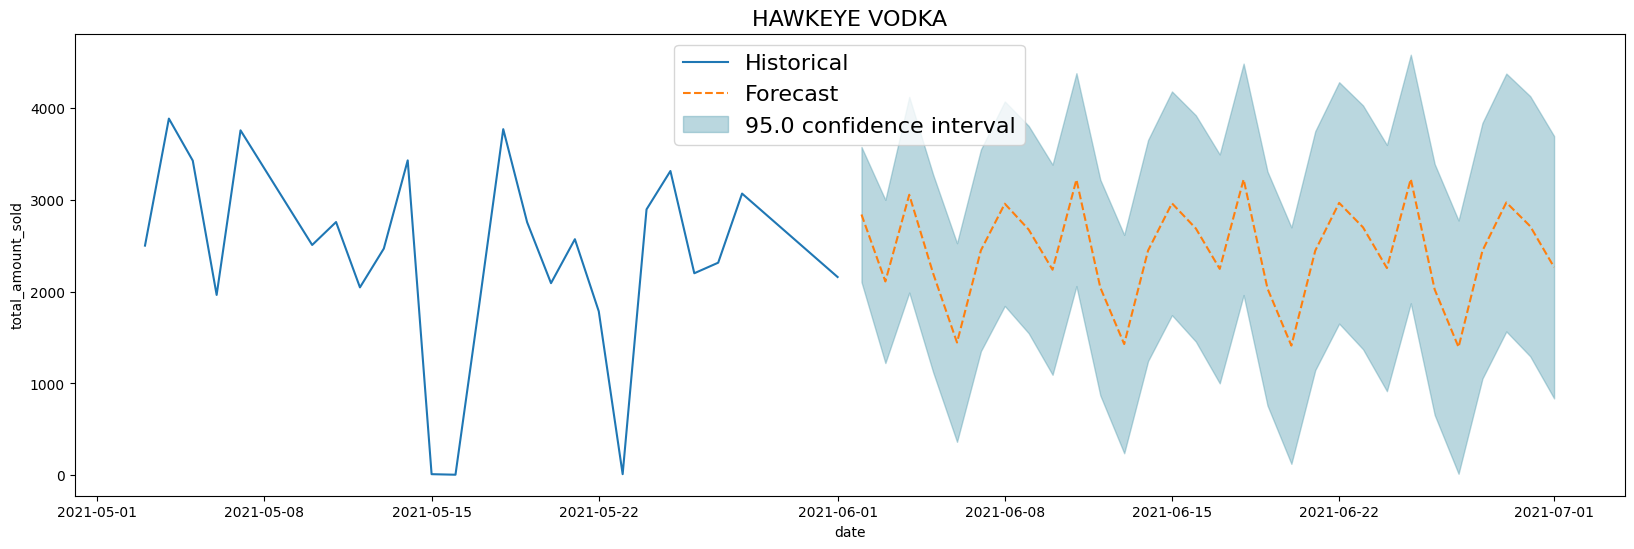

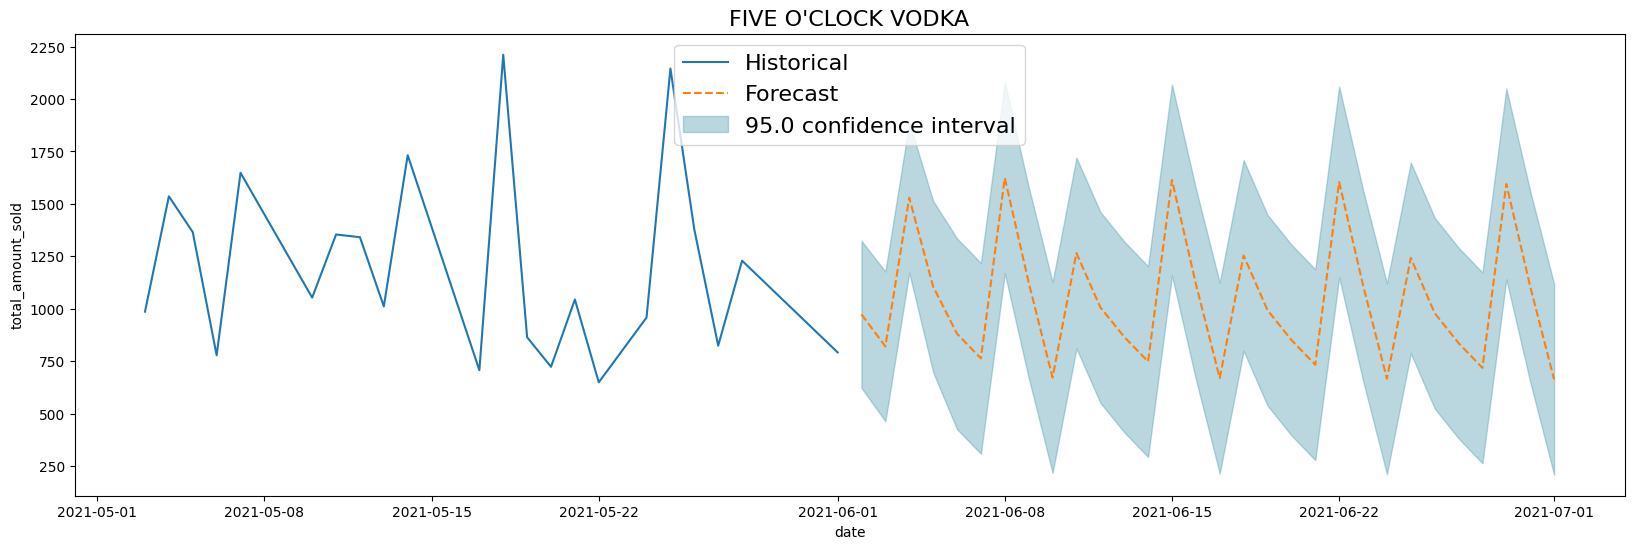

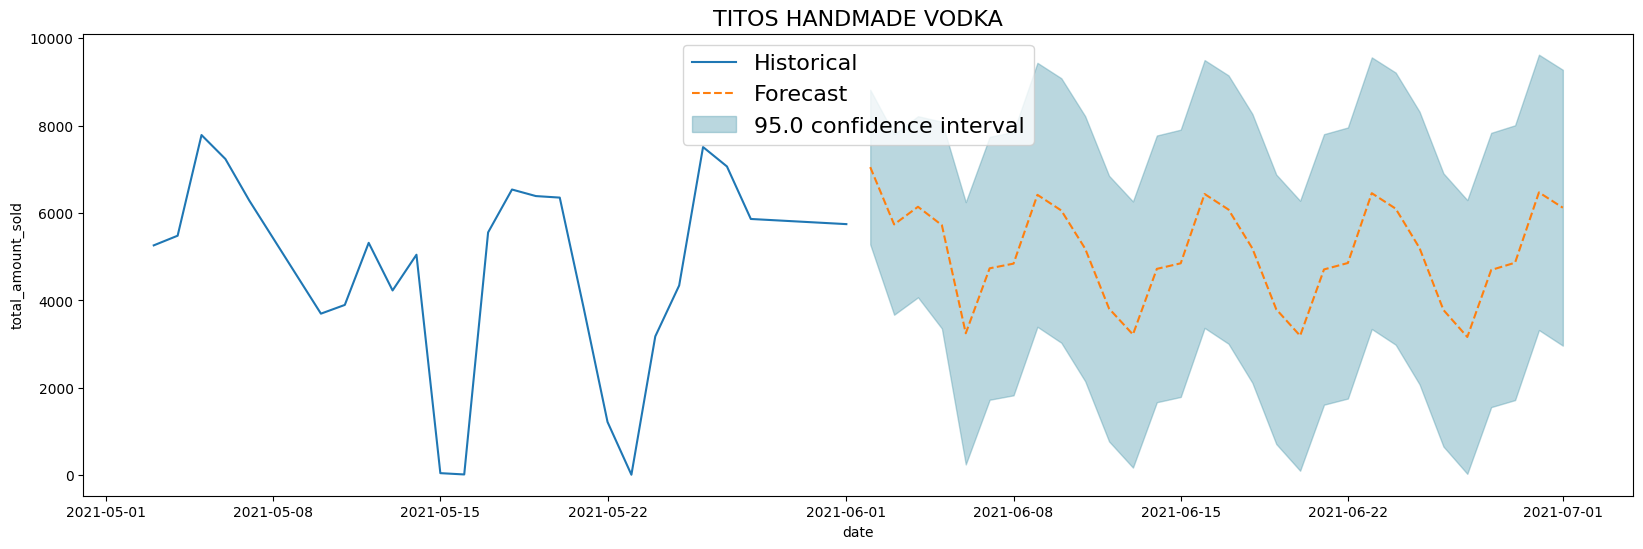

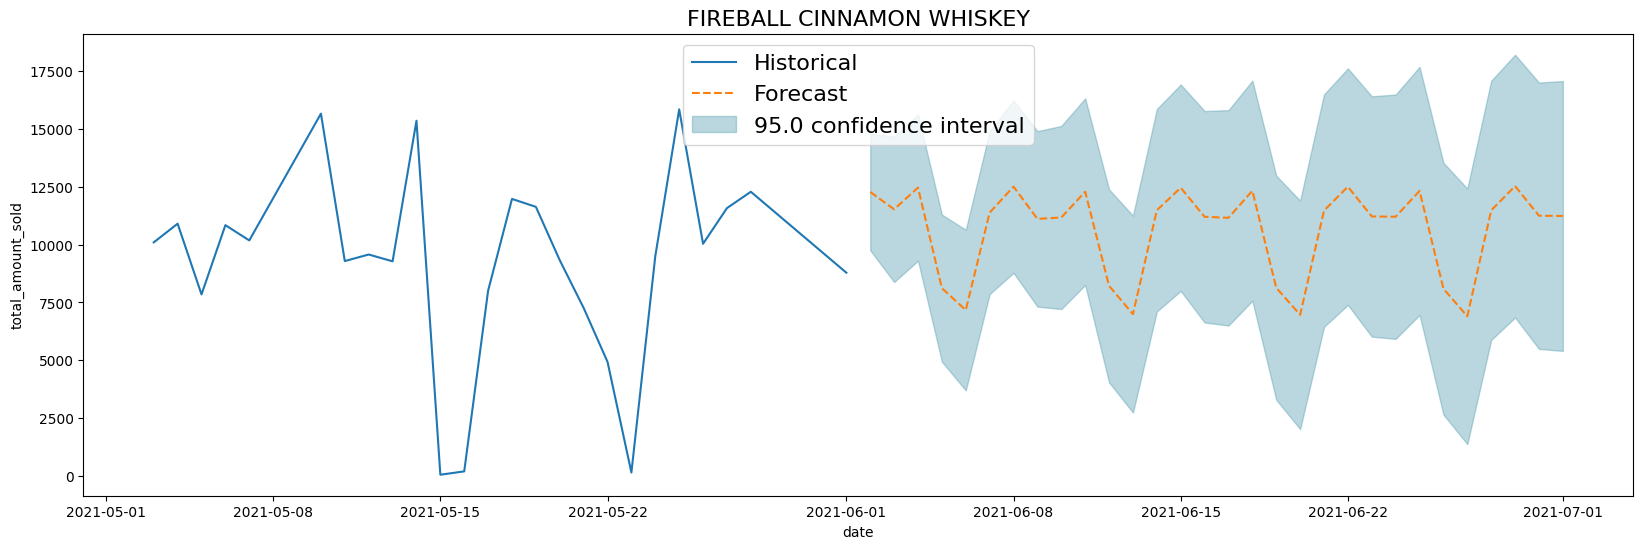

In [33]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    datah = dfhistorical[dfhistorical.item_name==item].copy()
    dataf = dfforecast[dfforecast.item_name==item].copy()
    
    plot_historical_and_forecast(input_timeseries = datah, 
                                 timestamp_col_name = "date", 
                                 data_col_name = "total_amount_sold", 
                                 forecast_output = dataf, 
                                 actual = None,
                                 title = item,
                                 plotstartdate = "2021-05-01")

#### Plot the forecasted predictions against the actual data

In [34]:
%%bigquery dfactual --params $ARIMA_PARAMS --project $PROJECT_ID 

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast

SELECT 
    date,
    item_description AS item_name,
    SUM(bottles_sold) AS total_amount_sold
FROM
    `bigquery-public-data.iowa_liquor_sales.sales` 
GROUP BY
    date, item_name
HAVING 
    date BETWEEN DATE_ADD(@TRAININGDATA_ENDDATE, 
                              INTERVAL 1 DAY) 
            AND DATE_ADD(@TRAININGDATA_ENDDATE, 
                             INTERVAL 1+CAST(HORIZON AS INT64) DAY) 
ORDER BY
    date;

Query is running:   0%|          |

Downloading:   0%|          |

In [35]:
dfactual.head()

,date,item_name,total_amount_sold
0,2021-06-02,CANADIAN LTD WHISKY,401
1,2021-06-02,CANADIAN RESERVE WHISKY,65
2,2021-06-02,JACK DANIELS OLD #7 BLACK LABEL,2496
3,2021-06-02,BIRD DOG PEACH,139
4,2021-06-02,FIVE O'CLOCK GIN,331


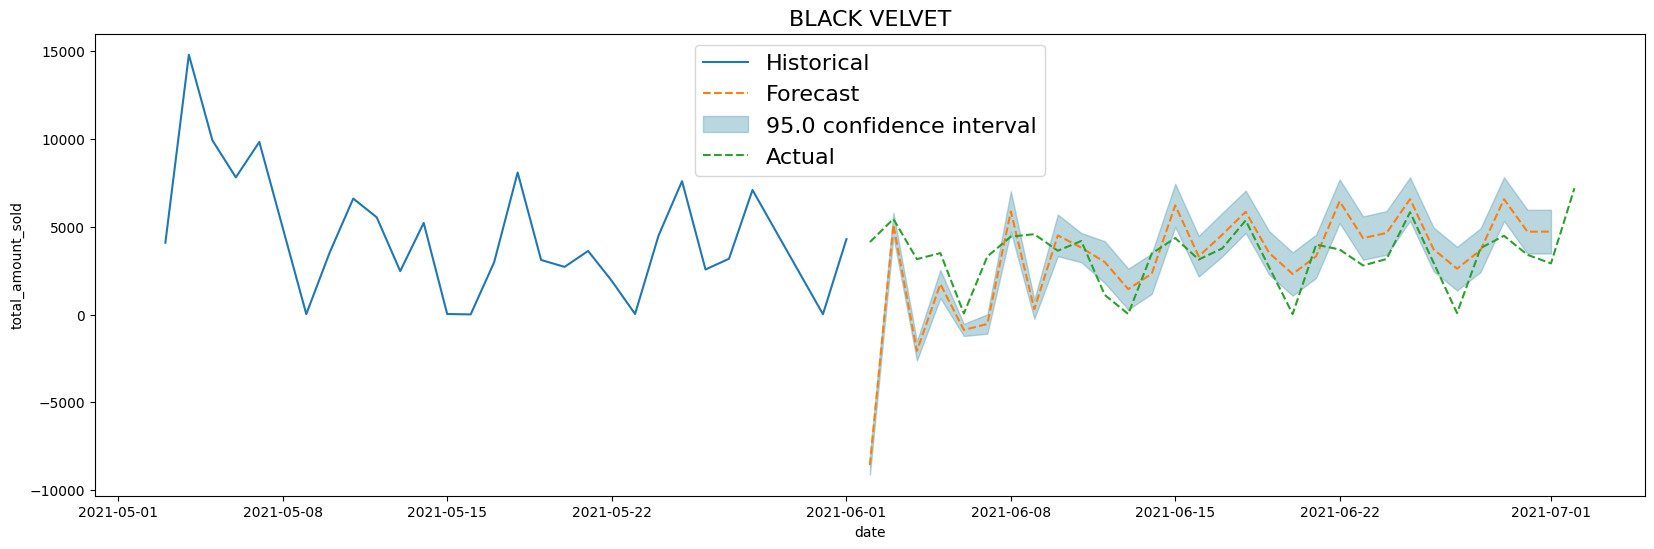

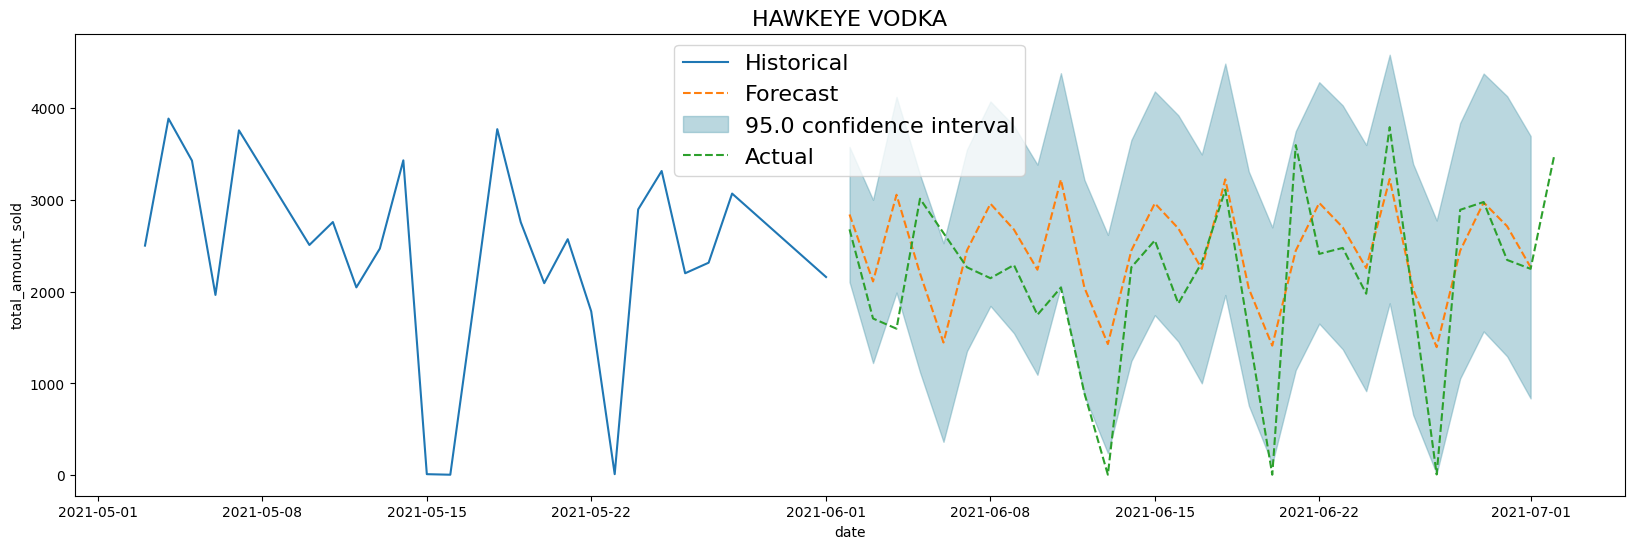

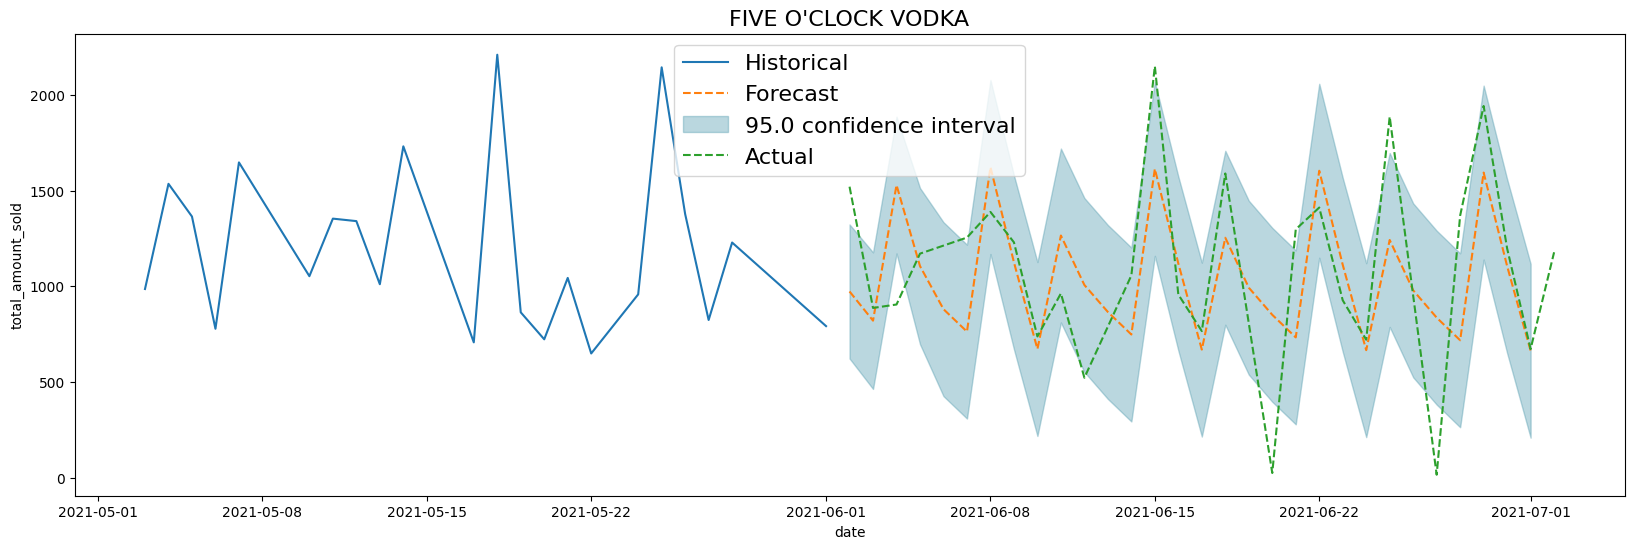

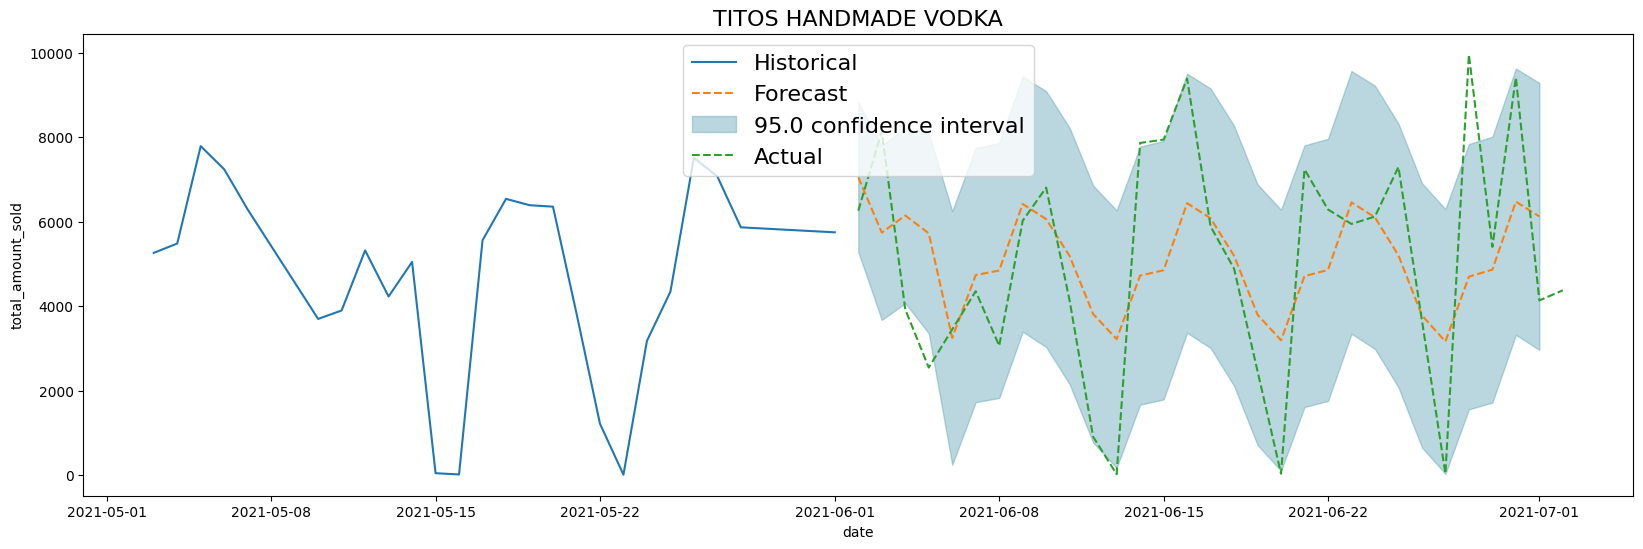

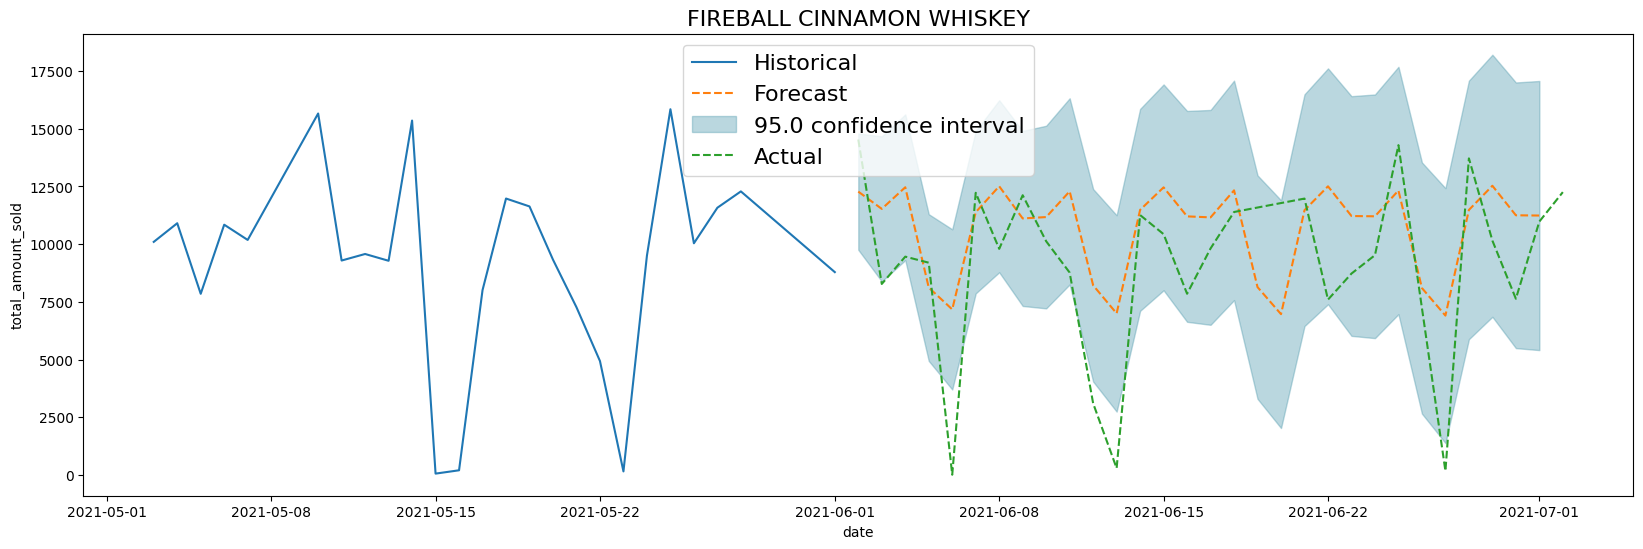

In [36]:
itemslist = list(dfhistorical.item_name.unique())

for item in itemslist:
    datah = dfhistorical[dfhistorical.item_name==item].sort_values('date')
    dataf = dfforecast[dfforecast.item_name==item].sort_values(['forecast_timestamp'])
    dataa = dfactual[dfactual.item_name==item].sort_values('date')
    plot_historical_and_forecast(input_timeseries = datah, 
                             timestamp_col_name = "date", 
                             data_col_name = "total_amount_sold", 
                             forecast_output = dataf, 
                             actual = dataa,
                             title = item,
                             plotstartdate = "2021-05-01")

## Create a dashboard with Data Studio

In [37]:
%%bigquery --params $ARIMA_PARAMS  --project $PROJECT_ID 

CREATE OR REPLACE VIEW bqmlforecast.outputdata_datastudio AS (
  SELECT
    date AS timestamp,
    item_name,
    total_amount_sold AS history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
  FROM
    bqmlforecast.training_data
  UNION ALL
  SELECT
    EXTRACT(DATE
    FROM
      forecast_timestamp) AS timestamp,
    item_name,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
  FROM
    ML.FORECAST(MODEL bqmlforecast.arima_model,
      STRUCT(30 AS horizon, 0.9 AS confidence_level)) 
  ORDER BY timestamp
  )

Query is running:   0%|          |

""
